# 1. Evolution of Emotion in Daily Conversations
In this part of assigment, I looked at the evolotion, change, of emotions throughout a conversation for both speakers.

## 1.1 Distribution of Emotion
More specificly, I looked at the distribuion of the followings
- emotions in general
- emotions per topic
- emotions per act(intention) of message
- emotoins per topic and per action
- emotions at the start of conversations per topic
- emotions at the end of conversatoins per topic
- change in emotions for the first speaker of the conversations per topic
- change in emotions for the second speaker of the conversations per topic

and my observations are,
- there is a high peak at zero for emotions
- in all topics, the medians of emotions are around zero. The categories of "ordinary lif", "relationship" and "attitude_emotion" have a long tail of outliers in the negative area.
- distribution of the end emotion is more compact and close to zero. However some topics have a large number of outliers. 


## 1.2 Top Changes in Emotion
Next, I looked at the top 3 conversations with the most decreasing(increasing) change of emotion for both speakers. It seems those top changes happen when the topic of conersation is "Relationship" or "Ordinary Life", which it makes sense that people might become more/les emotional as they speak to the loved ones. I was expecting the topic of "Politics" to have variance/outliers in change of emotions, which it does not according this dataset.
Here are more details,
- The top 3 conversations with positive change in emotion for the first speaker. Those conversations belong to the category "Relationship".
- The top 3 conversations with negative change in emotion for the first speaker. Those conversations belong to the category "Ordinary Life".
- The top 3 conversations with a positive change in emotion for the second speaker. Those conversations belong to the category "Relationship", "Ordinary Life" and "school life".
- The top 3 conversations with the largest negative change in emotion for the second speaker. Those conversations belong to the category "Relationship".

## 1.3 Effect of Act (Intention) of  Utterance
Finally, I was interested in finding out whether a conversation with a specific act would change the emotion in a conversation. For instance, asking too many questions might turn a conversation to sour. To do so, I calculated the proportion of each of the four acts in all dialogues and look at the relationship between the change in the emotion and those values. However, I did not observe any correlation. This could be due the fact I have calculated the proportion of each act for the entire conversation and not for each speaker individually. 
The only interesting observation was that the proportion of act inform is inversely correlated with the act commmisive and directive.

In [3]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from textblob import TextBlob

In [118]:
input_directory = '/Users/zahra/git/loris_ai_data_challenge/data'

conversations_text = 'dialogues_text.txt'
conversations_emotion = 'dialogues_emotion.txt'
conversations_topic = 'dialogues_topic.txt'
conversations_action = 'dialogues_act.txt'

topic_dict = {'1': 'Ordinary Life', '2': 'School Life', '3': 'Culture_Education',
              '4': 'Attitude_Emotion', '5': 'Relationship', '6': 'Tourism', 
              '7': 'Health', '8': 'Work', '9': 'Politics', '10': 'Finance'}

action_dict = {'1': 'inform', '2': 'question', '3': 'directive', '4': 'commissive'}

emotion_dict = {'0': 'no emotion', '1': 'anger', '2': 'disgust', '3': 'fear', '4': 
                'happiness', '5': 'sadness', '6': 'surprise'}

emotion_dict_adhoc = {'0': 0.0, '1': -1, '2': -0.5, '3': -0.25, '4': +1, '5': -0.25, '6': 0.75}

In [6]:
def convert_topic(topic):
    return topic_dict[topic]

In [7]:
def convert_action(act):
    return action_dict[act]

In [8]:
def load_conversations():
    ''' 
    this function loads all the conversations along with their 
    human labeled emotions, intentions, and topic to a list
    '''
    
    dial_dir = os.path.join(input_directory, conversations_text)
    emo_dir = os.path.join(input_directory, conversations_emotion)
    act_dir = os.path.join(input_directory, conversations_action)
    topic_dir = os.path.join(input_directory, conversations_topic)
    
    # Open files
    in_dial = open(dial_dir, 'r')
    in_emo = open(emo_dir, 'r')
    in_act = open(act_dir, 'r')
    in_topic = open(topic_dir, 'r')
    
    # build a list of dictionaries: a dictionary per dialogue
    conversations_list = [
        {
            'utterances': utterances,
            'emotions': emotions,
            'actions': actions,
            'topic': convert_topic(topic)
        }
        for utterances, emotions, actions, topic in (
            (dialogue.split('__eou__')[:-1], 
             emotion.split(), 
             action.split(), 
             topic.strip())
            for dialogue, emotion, action, topic in zip(in_dial, in_emo, in_act, in_topic)
        )
        if len(utterances) == len(emotions) == len(actions)
    ]
            
    return conversations_list

In [9]:
def find_sentiment(conversation_dict):
    '''
    this function finds the sentiment of each utterance of a conversation using the blob library
    '''
    
    conversation_text = conversation_dict['utterances']
    conversation_emotion = [int(elem) for elem in conversation_dict['emotions']]
    conversation_emotion_blob = []
    
    for sentence in conversation_text:
        blob = TextBlob(sentence)
        conversation_emotion_blob.append(blob.sentiment.polarity)
        
    conversation_dict['blob_emotions'] = conversation_emotion_blob

In [29]:
def find_sentiments_for_all(conversations_list):
    '''
    this function finds the change of emotion for each speaker in a conversation 
    '''
    
    for conversation_dict in conversations_list:
        find_sentiment(conversation_dict)
        first_speaker, second_speaker = conversation_dict['blob_emotions'][::2], conversation_dict['blob_emotions'][1::2]  
        conversation_dict['change_in_emotions_first_speaker'] = first_speaker[-1]-first_speaker[0]
        conversation_dict['change_in_emotions_sec_speaker'] = second_speaker[-1]-second_speaker[0]

In [11]:
def find_actions_proportion(conversation_list):
    '''
    this function calculates the proportion of each act in a conversation
    '''
    
    for conversation_dict in conversation_list:
        
        actions_list = conversation_dict['actions']
        for key, value in action_dict.items():
            conversation_dict['prop_'+value] = actions_list.count(key)/len(actions_list)


In [78]:
def smooth_emotions_list(emotions_list):
    '''
    this function smooths out a list of emotions using interpolation
    '''
    
    if len(emotions_list) >= 3:
        x = np.linspace(0, len(emotions_list), num=10, endpoint=True)
        smooth_fun = interp1d(range(len(emotions_list)), emotions_list, 
                              kind='quadratic', fill_value="extrapolate")
        y = smooth_fun(x)
    else:
        x = range(len(emotions_list))
        y = emotions_list

    return x, y

In [79]:
def plot_emotions(first_speaker_emotions, second_speaker_emotions):
    '''
    this function plots the emotions for both speakers of a conversation
    '''
    plt.figure(figsize=(10, 4))
    
    x, y = smooth_emotions_list(first_speaker_emotions)
        
    plt.subplot(1, 2, 1)
    plt.plot(x, y)
    plt.ylabel('Emotion Value')
    plt.xlabel('Time')
    plt.ylim((-1, +1))
    plt.axhline(0, color='black', ls='--')
    plt.title('First speaker\'s Emotions vs. Time')
    
    x, y = smooth_emotions_list(second_speaker_emotions)

    plt.subplot(1, 2, 2)
    plt.plot(x, y)
    plt.ylabel('Emotion Value')
    plt.xlabel('Time')
    plt.ylim((-1, +1))
    plt.axhline(0, color='black', ls='--')
    plt.title('Second speaker\'s Emotions vs. Time')
    plt.show()

In [99]:
conversations_list = load_conversations()
print("Number of conversatoins: ", len(conversations_list))

Number of conversatoins:  13117


In [100]:
find_sentiments_for_all(conversations_list)

In [101]:
find_actions_proportion(conversations_list)
emotions_df = pd.DataFrame(conversations_list)

In [119]:
messages = {'emotions': [], 'topics': [], 'actions': [], 'human_labeled_emotions': []}

for conversation_dict in conversations_list:
    messages['emotions'].extend(conversation_dict['blob_emotions'])
    
    human_labeled_emotions = [emotion_dict_adhoc[emotion] for emotion in conversation_dict['emotions']]
    messages['human_labeled_emotions'].extend(human_labeled_emotions)

    actions = [convert_action(act) for act in conversation_dict['actions']]
    messages['actions'].extend(actions)
    
    topics = [conversation_dict['topic']] * len(conversation_dict['actions'])
    messages['topics'].extend(topics)
    
print('Total messages:', len(messages['emotions']), len(messages['topics']), len(messages['actions']))
messages_df = pd.DataFrame(messages)
messages_df.head(2)

Total messages: 102968 102968 102968


,actions,emotions,human_labeled_emotions,topics
0,directive,-0.6,-0.5,Ordinary Life
1,commissive,0.0,0.0,Ordinary Life


### Distribution of emotion in general

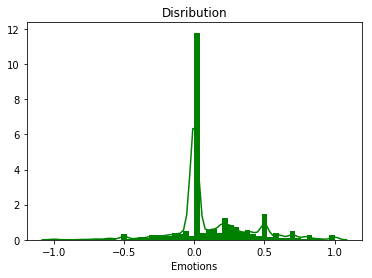

In [105]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.distplot(messages_df['emotions'], kde=True, color='green', hist_kws=dict(alpha=1))
plt.xlabel('Emotions')
plt.title('Disribution')
plt.show()

### Distribution of emotion per topic and per intention

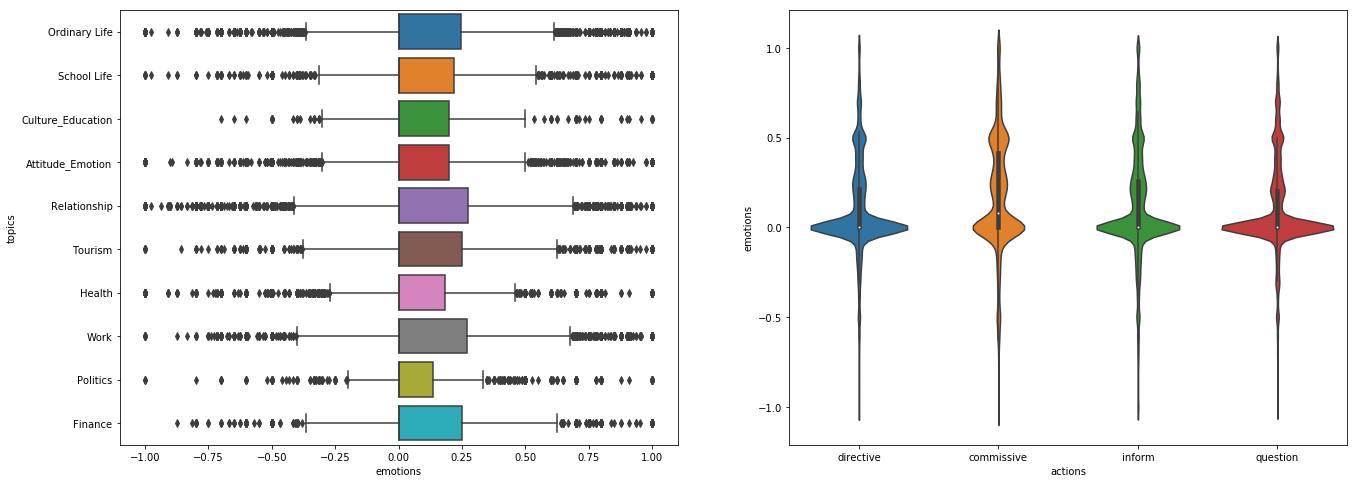

In [111]:
fig, ax = plt.subplots(figsize=(22, 8))
plt.subplot(1, 2, 1)
sns.boxplot(y='topics', x='emotions', data=messages_df)

plt.subplot(1, 2, 2)
sns.violinplot(x='actions', y='emotions', data=messages_df)

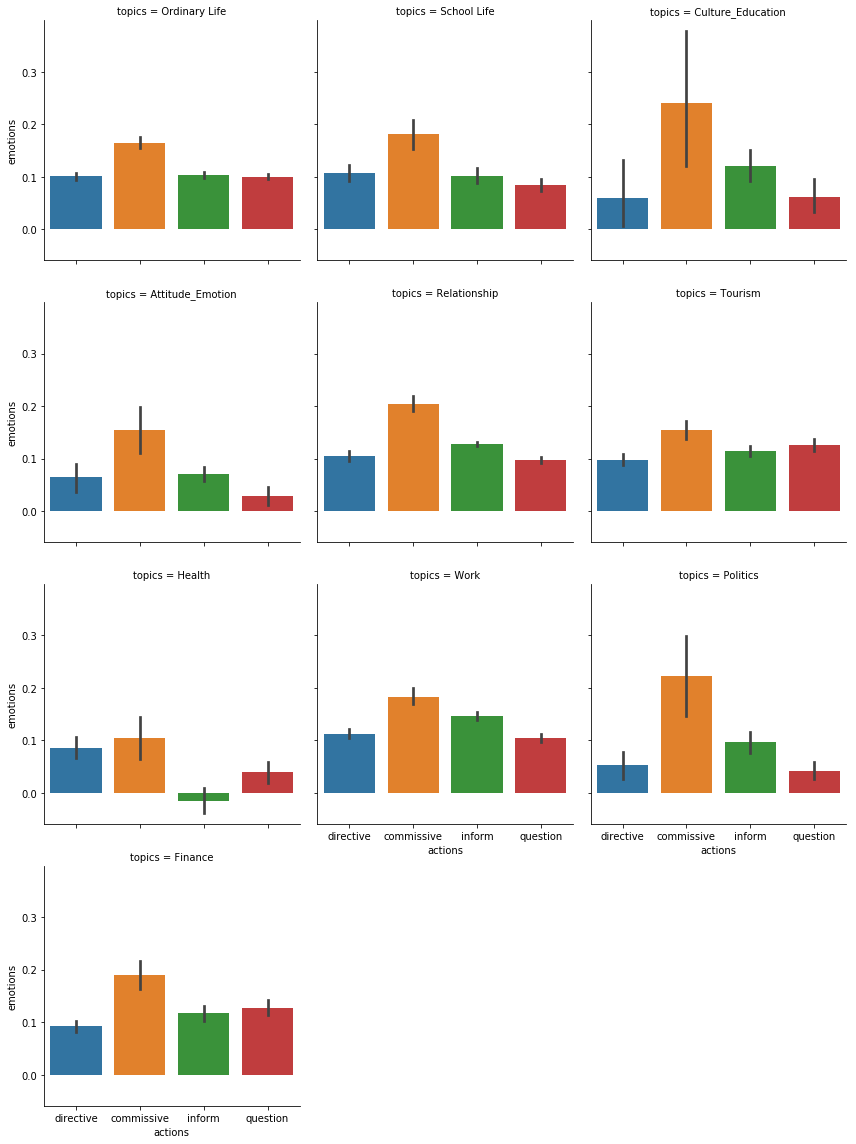

In [74]:
g = sns.factorplot(col="topics", y="emotions", x="actions", data=messages_df, 
                   kind="bar", col_wrap=3, size=4)

plt.show()

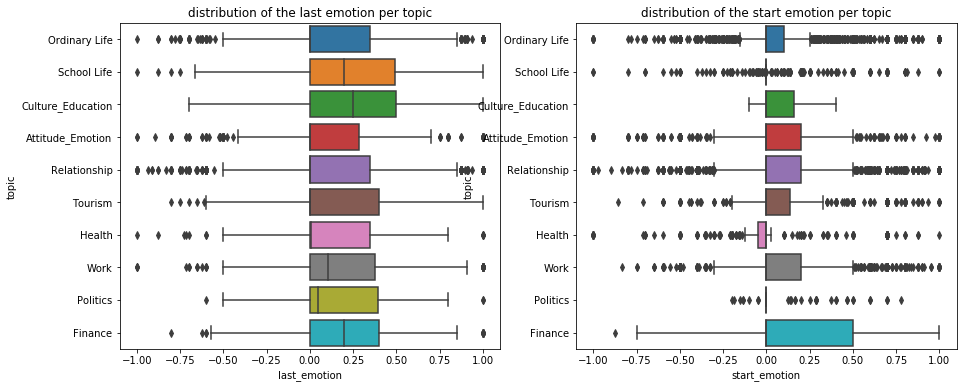

In [113]:
emotions_df['last_emotion'] = [emotions[-1] for emotions in emotions_df['blob_emotions']]
emotions_df['start_emotion'] = [emotions[0] for emotions in emotions_df['blob_emotions']]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y='topic', x='last_emotion', data=emotions_df)
plt.title("distribution of the last emotion per topic")

plt.subplot(1, 2, 2)
sns.boxplot(y='topic', x='start_emotion', data=emotions_df)
plt.title("distribution of the start emotion per topic")
plt.show()

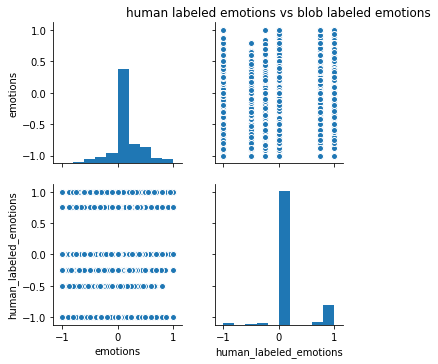

In [124]:
sns.pairplot(data=messages_df[['emotions',
                               'human_labeled_emotions']], 
             kind="scatter")
plt.title('human labeled emotions vs blob labeled emotions')
plt.show()

### Distribution of change in emotion per speaker

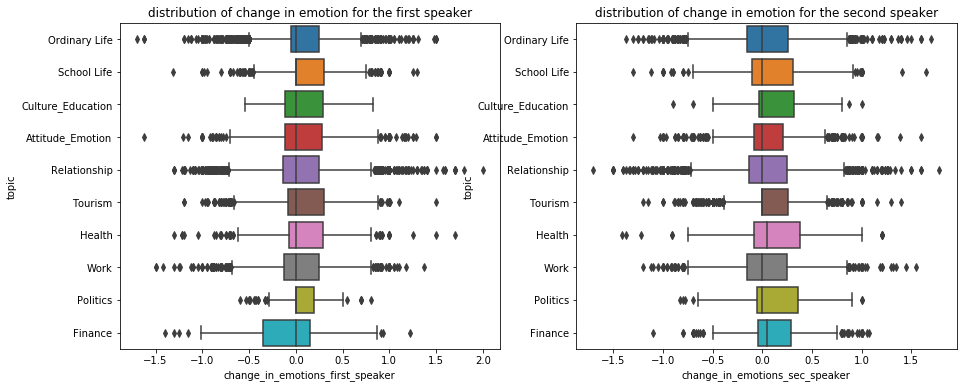

In [114]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y='topic', x='change_in_emotions_first_speaker', data=emotions_df)
plt.title("distribution of change in emotion for the first speaker")

plt.subplot(1, 2, 2)
sns.boxplot(y='topic', x='change_in_emotions_sec_speaker', data=emotions_df)
plt.title("distribution of change in emotion for the second speaker")
plt.show()

### Top conversations with the largest change

actions                                                      [2, 1, 2, 2, 2, 1, 2, 1]
blob_emotions                       [-1.0, 0.0, -0.3125, 0.0625, -0.3125, 0.2, 1.0...
change_in_emotions_first_speaker                                                    2
change_in_emotions_sec_speaker                                               0.128788
emotions                                                     [0, 0, 0, 0, 0, 0, 0, 0]
prop_commissive                                                                     0
prop_directive                                                                      0
prop_inform                                                                     0.375
prop_question                                                                   0.625
topic                                                                    Relationship
utterances                          [What's the matter with you , then ? You look ...
last_emotion                                          

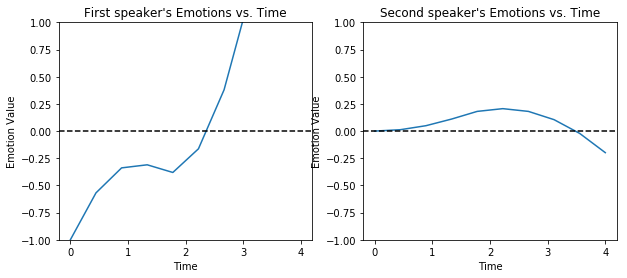

actions                                          [1, 1, 1, 2, 1, 2, 1, 2, 1, 3, 4, 2]
blob_emotions                       [-1.0, 0.0, 0.0, 0.5, 0.0, -0.0499999999999999...
change_in_emotions_first_speaker                                                  1.8
change_in_emotions_sec_speaker                                                    0.5
emotions                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4]
prop_commissive                                                             0.0833333
prop_directive                                                              0.0833333
prop_inform                                                                       0.5
prop_question                                                                0.333333
topic                                                                    Relationship
utterances                          [The weather is terrible . ,  Yeah . It's been...
last_emotion                                          

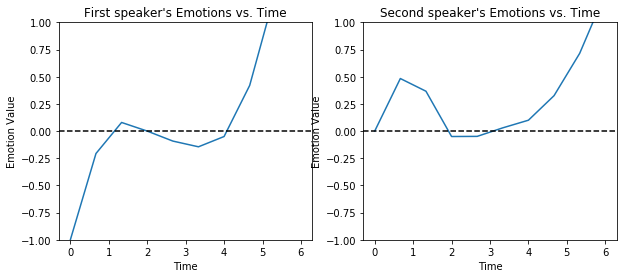

actions                                                   [1, 1, 1, 1, 2, 2, 1, 3, 4]
blob_emotions                       [-1.0, 0.16944444444444443, -0.2, 0.5, 0.0, 0....
change_in_emotions_first_speaker                                                  1.7
change_in_emotions_sec_speaker                                              -0.169444
emotions                                                  [0, 0, 0, 0, 0, 0, 4, 4, 4]
prop_commissive                                                              0.111111
prop_directive                                                               0.111111
prop_inform                                                                  0.555556
prop_question                                                                0.222222
topic                                                                    Relationship
utterances                          [The weather is terrible . ,  Yes . It was sun...
last_emotion                                          

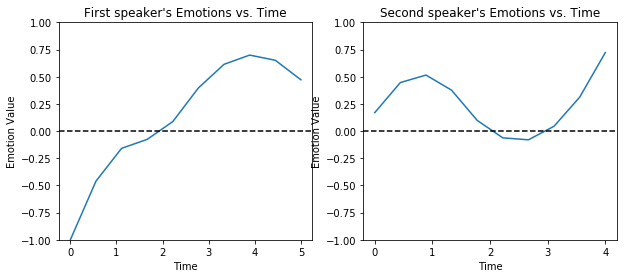

In [80]:
largest_change = emotions_df.nlargest(3, 'change_in_emotions_first_speaker', keep='first')

for index, row in largest_change.iterrows():
    print(row)
    row_dict = row.to_dict()
    plot_emotions(row_dict['blob_emotions'][::2], row_dict['blob_emotions'][1::2])
     

actions                                                            [1, 1, 2, 1, 2, 1]
blob_emotions                       [0.5392857142857143, -0.78125, 0.0, 0.0, 0.0, ...
change_in_emotions_first_speaker                                            -0.539286
change_in_emotions_sec_speaker                                                1.78125
emotions                                                           [0, 0, 0, 0, 0, 0]
prop_commissive                                                                     0
prop_directive                                                                      0
prop_inform                                                                  0.666667
prop_question                                                                0.333333
topic                                                                    Relationship
utterances                          [I'll tell you something that's good about act...
last_emotion                                          

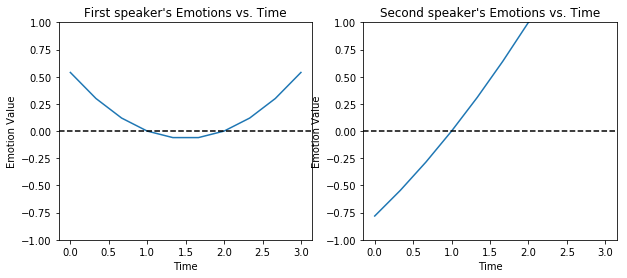

actions                                                               [2, 1, 3, 4, 1]
blob_emotions                             [0.0, -0.6999999999999998, -0.1, 1.0, 0.25]
change_in_emotions_first_speaker                                                 0.25
change_in_emotions_sec_speaker                                                    1.7
emotions                                                              [0, 0, 0, 0, 0]
prop_commissive                                                                   0.2
prop_directive                                                                    0.2
prop_inform                                                                       0.4
prop_question                                                                     0.2
topic                                                                   Ordinary Life
utterances                          [How was your test ? ,  It was bad . ,  Oh , h...
last_emotion                                          

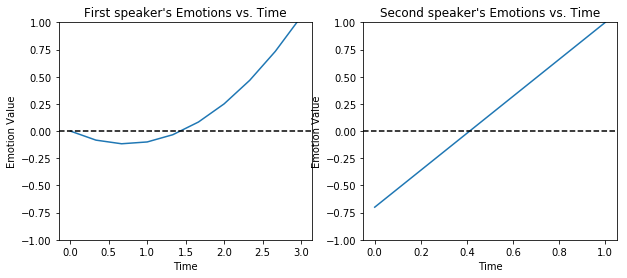

actions                                                               [2, 1, 3, 4, 1]
blob_emotions                                             [0.0, -0.65, 0.0, 1.0, 0.7]
change_in_emotions_first_speaker                                                  0.7
change_in_emotions_sec_speaker                                                   1.65
emotions                                                              [0, 0, 0, 0, 0]
prop_commissive                                                                   0.2
prop_directive                                                                    0.2
prop_inform                                                                       0.4
prop_question                                                                     0.2
topic                                                                     School Life
utterances                          [How are you getting along with your paper ? ,...
last_emotion                                          

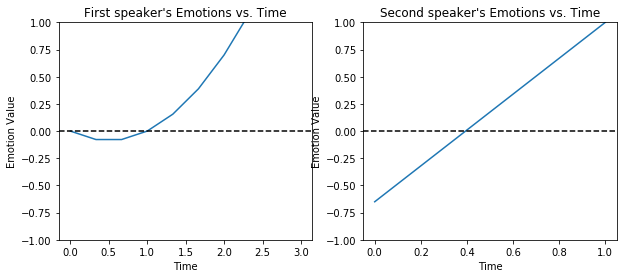

In [81]:
largest_change = emotions_df.nlargest(3, 'change_in_emotions_sec_speaker', keep='first')

for index, row in largest_change.iterrows():
    print(row)
    row_dict = row.to_dict()
    plot_emotions(row_dict['blob_emotions'][::2], row_dict['blob_emotions'][1::2])


actions                                                [2, 1, 2, 1, 2, 1, 2, 1, 1, 1]
blob_emotions                       [0.5, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, -0.25...
change_in_emotions_first_speaker                                                -0.75
change_in_emotions_sec_speaker                                                   -1.7
emotions                                               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
prop_commissive                                                                     0
prop_directive                                                                      0
prop_inform                                                                       0.6
prop_question                                                                     0.4
topic                                                                    Relationship
utterances                          [What's your favorite hobby ? ,  I'd like read...
last_emotion                                          

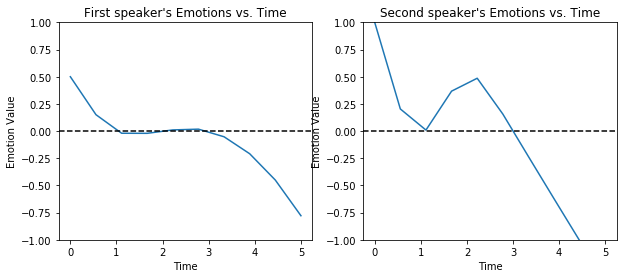

actions                                                      [3, 2, 2, 1, 1, 2, 2, 1]
blob_emotions                          [0.0, 0.5, 0.8, 0.7, 0.0, -0.6, -0.3125, -1.0]
change_in_emotions_first_speaker                                              -0.3125
change_in_emotions_sec_speaker                                                   -1.5
emotions                                                     [0, 0, 0, 0, 0, 0, 0, 0]
prop_commissive                                                                     0
prop_directive                                                                  0.125
prop_inform                                                                     0.375
prop_question                                                                     0.5
topic                                                                    Relationship
utterances                          [Hey , Mike . Can I ask you something ? ,  Sur...
last_emotion                                          

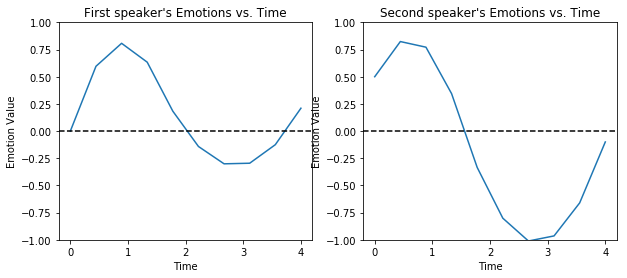

actions                                                      [3, 2, 2, 1, 1, 2, 2, 2]
blob_emotions                          [0.0, 0.5, 0.8, 0.7, 0.0, -0.6, -0.3125, -1.0]
change_in_emotions_first_speaker                                              -0.3125
change_in_emotions_sec_speaker                                                   -1.5
emotions                                                     [0, 0, 0, 0, 0, 6, 0, 0]
prop_commissive                                                                     0
prop_directive                                                                  0.125
prop_inform                                                                      0.25
prop_question                                                                   0.625
topic                                                                    Relationship
utterances                          [Hey , Mike . Can I ask you something ? ,  Sur...
last_emotion                                          

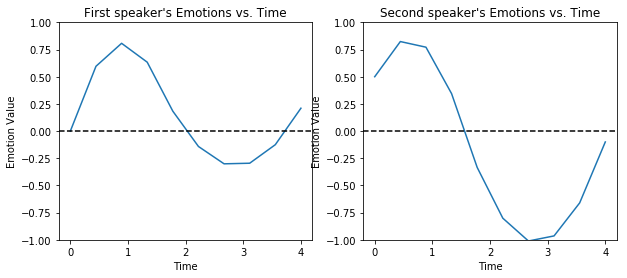

In [82]:
largest_change = emotions_df.nsmallest(3, 'change_in_emotions_sec_speaker', keep='first')

for index, row in largest_change.iterrows():
    print(row)
    row_dict = row.to_dict()
    plot_emotions(row_dict['blob_emotions'][::2], row_dict['blob_emotions'][1::2])

### Effects of Acts on Emotions

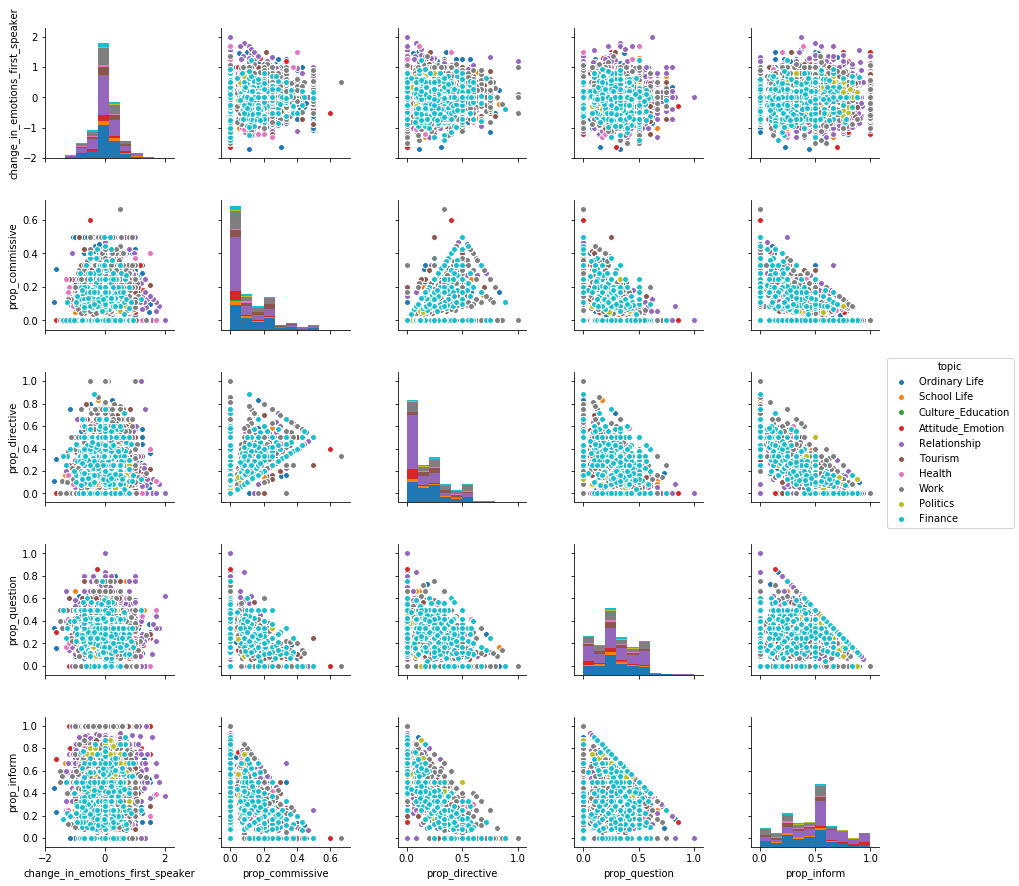

In [96]:
sns.pairplot(data=emotions_df[['change_in_emotions_first_speaker',
                               'prop_commissive', 
                               'prop_directive', 
                               'prop_question', 
                               'prop_inform',
                               'topic']], 
             hue='topic',
             kind="scatter")
plt.show()

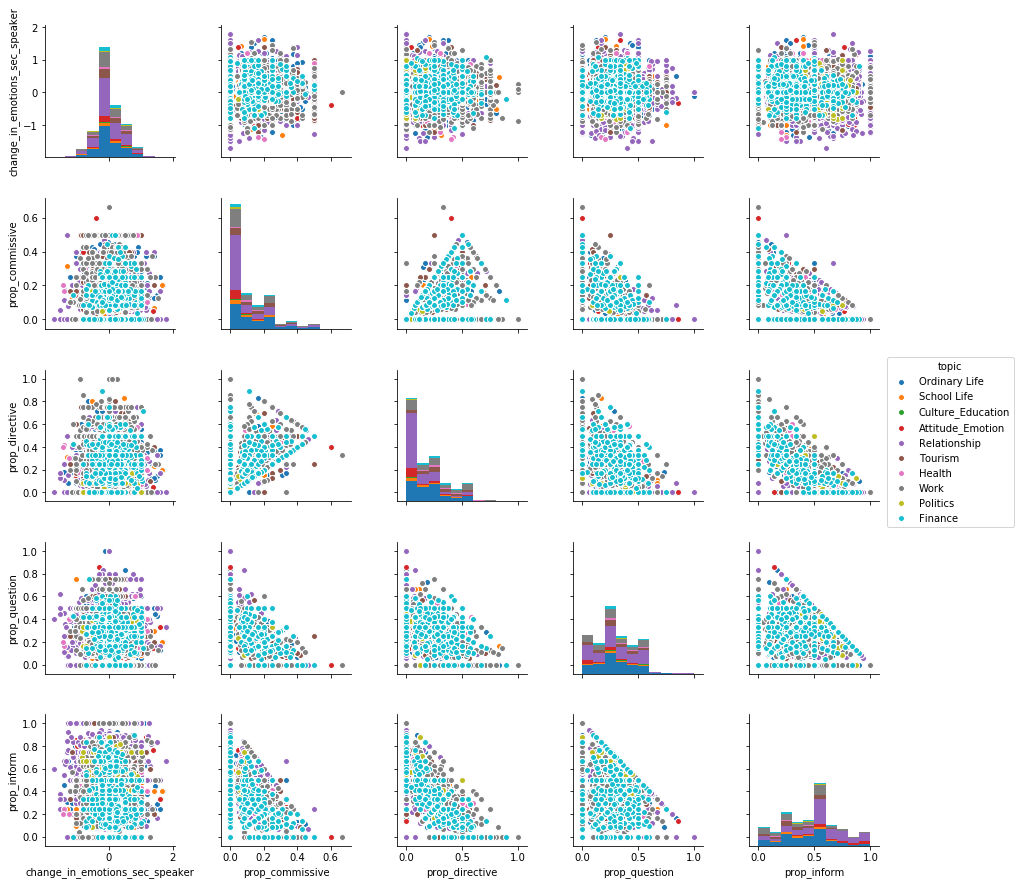

In [95]:
sns.pairplot(data=emotions_df[['change_in_emotions_sec_speaker', 
                               'prop_commissive', 
                               'prop_directive', 
                               'prop_question', 
                               'prop_inform',
                               'topic']], 
             hue='topic',
             kind="scatter")
plt.show()

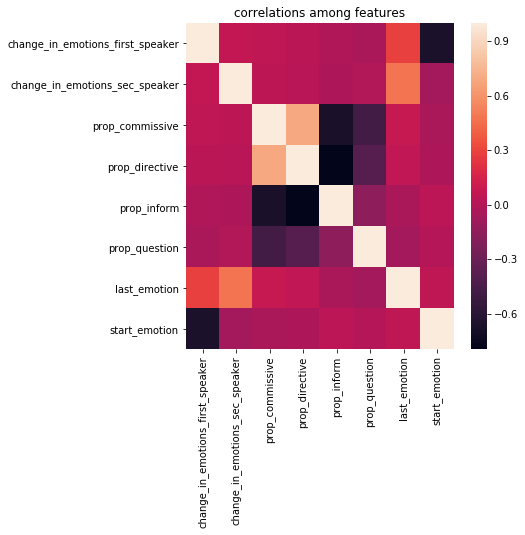

In [112]:
corr = emotions_df.corr()
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)
plt.title("correlations among features")
plt.show()